# Converting netCDF to Zarr

## CM2.6 Ocean Surface Fields

This notebook demonstrates the various tricks (hacks?) that I use when converting existing netCDF datasets to zarr datasets using xarray.
A key concept is the following: _many netCDF files will become one single zarr dataset._
You need to decide what are the individual zarr datasets you want to produce. This depends on the scientific application.
In general, for model simulations, my approach is to contatenate all the time snapshots of a specific file
(e.g. `01810101.ocean_bdy_flux.nc`, `01810201.ocean_bdy_flux.nc`) into a single zarr dataset.

The steps are as follows:

1. **Understand the structure and content of the netCDF files.** Make sure that the files you are trying to combine are actually consistent in terms of the variables they contain, coordinates, etc. 
1.  **Open the all the netCDF files using `xarray.open_mfdataset`.** I usually start by opening a single file first using `open_dataset`. For example, do you want to decode CF conventions? (Note that decoding is not strictly necessary; the encoding attributes will be passed along to zarr allowing the zarr dataset to be decoded later.) Do you want to drop certain variabiles? Trial and error is usually required to get the dataset to look right.
1. **Define the extra encoding options for zarr.** This mostly means deciding what [zarr compressor](https://zarr.readthedocs.io/en/v2.1.3/tutorial.html#compressors) to use. Experimentation with different compression types and rates is encouraged.
1. **D

In [1]:
import xarray as xr
from glob import glob
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
import zarr

%matplotlib inline

In [2]:
zarr.__version__

'2.2.1.dev125'

In [3]:
xr.__version__

'0.11.1+19.gf13536c'

In [5]:
#client = Client('tcp://129.236.21.48:9786')
client = Client(ip='*', n_workers=8, threads_per_worker=1)
client

Client Scheduler: tcp://129.236.21.48:36042 Dashboard: http://129.236.21.48:8787/status,Cluster Workers: 8 Cores: 8 Memory: 120.21 GB


In [4]:
experiment = 'one_percent'

base_dir = '/swot/SUM01/CM2.6'

ddir = os.path.join(base_dir, experiment)
prefix = 'ocean_bdy_flux'
drop_vars = ['average_T1', 'average_T2', 'average_DT', 'time_bounds']
extra_coord_vars = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c']

year_start, year_end = 181, 200
years = np.arange(year_start, year_end+1)
year_str = '%04d-%04d' % (year_start, year_end)

chunks = {'time': 1}

files = [os.path.join(ddir, '%04d0101.%s.nc' % (year, prefix))
         for year in years]

In [5]:
files[:2]

['/swot/SUM01/CM2.6/one_percent/01810101.ocean_bdy_flux.nc',
 '/swot/SUM01/CM2.6/one_percent/01820101.ocean_bdy_flux.nc']

In [6]:
open_kwargs = dict(drop_variables=(drop_vars + extra_coord_vars), chunks=chunks, decode_cf=True, decode_times=False)
ds = xr.open_mfdataset(files, parallel=True, **open_kwargs)
ds0 = xr.open_dataset(files[0], decode_cf=True, decode_times=False)[extra_coord_vars]
for cv in extra_coord_vars:
    ds.coords[cv] = ds0.coords[cv]
ds

<xarray.Dataset>
Dimensions:                    (nv: 2, time: 240, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean                   (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * yt_ocean                   (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
  * nv                         (nv) float64 1.0 2.0
  * xu_ocean                   (xu_ocean) float64 -279.9 -279.8 ... 79.9 80.0
  * yu_ocean                   (yu_ocean) float64 -81.09 -81.05 ... 89.96 90.0
  * time                       (time) float64 6.576e+04 6.579e+04 ... 7.303e+04
    geolat_t                   (yt_ocean, xt_ocean) float32 ...
    geolon_t                   (yt_ocean, xt_ocean) float32 ...
    geolat_c                   (yu_ocean, xu_ocean) float32 ...
    geolon_c                   (yu_ocean, xu_ocean) float32 ...
Data variables:
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<shape=(240, 2700, 3600), chunksize=(1, 2700, 3600)>
    ta

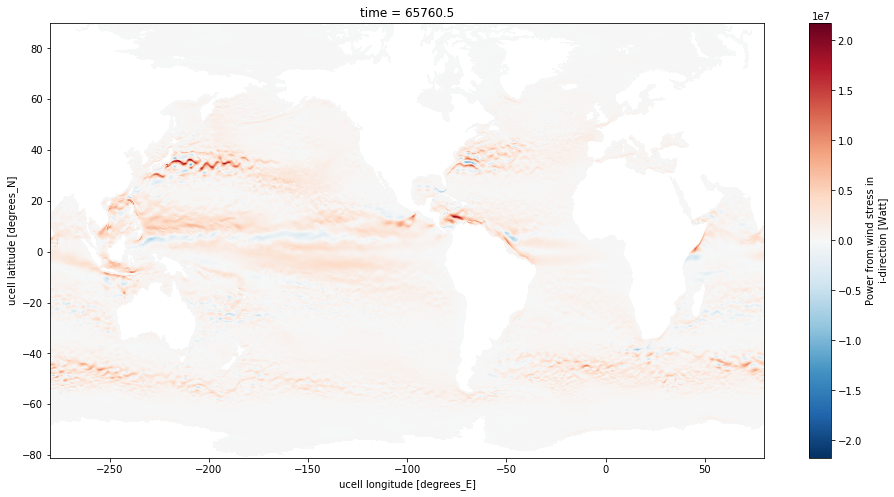

In [7]:
ds.wind_power_u[0].plot(figsize=(16, 8))

In [8]:
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
encoding = {vname: {'compressor': compressor} for vname in ds.variables}
outdir_base = '/swot/SUM03/tmp/CM2.6'
dsname = 'ocean_bdy_flux'
outdir = os.path.join(outdir_base, experiment, dsname)
outdir

'/swot/SUM03/tmp/CM2.6/one_percent/ocean_bdy_flux'

In [11]:
zs = ds.to_zarr(outdir, encoding=encoding, consolidated=True)

ValueError: path '' contains a group

In [12]:
# now check that it came out right
ds_z = xr.open_zarr(outdir, consolidated=True)
ds_z

<xarray.Dataset>
Dimensions:                    (nv: 2, time: 240, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
    geolon_c                   (yu_ocean, xu_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
  * nv                         (nv) float64 1.0 2.0
  * time                       (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean                   (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
  * xu_ocean                   (xu_ocean) float64 -279.9 -279.8 ... 79.9 80.0
  * yt_ocean                   (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
  * yu_ocean             

In [ ]:
# timing comparison
% time ds.tau_x.mean().load()

In [13]:
ds_z.time

<xarray.DataArray 'time' (time: 240)>
array([cftime.DatetimeJulian(181, 1, 16, 12, 0, 0, 5, -1, 1),
       cftime.DatetimeJulian(181, 2, 15, 0, 0, 0, 5, -1, 1),
       cftime.DatetimeJulian(181, 3, 16, 12, 0, 0, 5, -1, 1), ...,
       cftime.DatetimeJulian(200, 10, 16, 12, 0, 0, 5, -1, 1),
       cftime.DatetimeJulian(200, 11, 16, 0, 0, 0, 5, -1, 1),
       cftime.DatetimeJulian(200, 12, 16, 12, 0, 0, 5, -1, 1)], dtype=object)
Coordinates:
  * time     (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
Attributes:
    cartesian_axis:  T
    calendar_type:   JULIAN
    bounds:          time_bounds
    long_name:       time

In [ ]:
#experiment = 'one_percent'
experiment = 'control'

base_dir = '/swot/SUM01/CM2.6'

ddir = os.path.join(base_dir, experiment)
prefix = 'ocean_minibling_surf_field'
drop_vars = ['average_T1', 'average_T2', 'average_DT', 'time_bounds']

year_start, year_end = 181, 200
years = np.arange(year_start, year_end+1)
year_str = '%04d-%04d' % (year_start, year_end)

# tying to play around with chunks to improve performance
chunks = {'time':1}

files = [os.path.join(ddir, '%04d0101.%s.nc' % (year, prefix))
         for year in years]

# for some reason this does not work! it starts eagerly loading
#ds = xr.open_mfdataset(files[5:7],
#                       drop_variables=drop_vars,
#                       chunks=chunks, decode_cf=False)

open_kwargs = dict(drop_variables=drop_vars, chunks=chunks, decode_cf=True, decode_times=False)
dsets = [xr.open_dataset(file, **open_kwargs) for file in files]

In [17]:
# some files are missing sea-surface height
for dset in dsets:
    print(dset.data_vars)

Data variables:
    htotal        (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    kw            (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    surface_salt  (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    usurf         (time, yu_ocean, xu_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    vsurf         (time, yu_ocean, xu_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    irr_mix       (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 1, 2700, 3600), chunksize=(1, 1, 2700, 3600)>
    biomass_p     (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    chl           (time, yt_ocean,

In [36]:
test_var = next(iter(dset.data_vars.values()))
xr.zeros_like(test_var)

<xarray.DataArray 'htotal' (time: 366, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<shape=(366, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600)>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 -80.9 ...
  * time      (time) float64 7.268e+04 7.269e+04 7.269e+04 7.269e+04 ...
Attributes:
    long_name:      Surface H+ concentration
    units:          mol kg-1
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t

In [38]:
# get the full set of variables
all_data_vars = set()
data_var_attrs = {}
for dset in dsets:
    all_data_vars.update(set(dset.data_vars))
    for vname in dset.data_vars:
        data_var_attrs[vname] = dset[vname].attrs
data_var_attrs    

{'biomass_p': OrderedDict([('long_name', 'Surface Biomass-P concentration'),
              ('units', 'mol kg-1'),
              ('cell_methods', 'time: mean'),
              ('time_avg_info', 'average_T1,average_T2,average_DT'),
              ('coordinates', 'geolon_t geolat_t')]),
 'chl': OrderedDict([('long_name', 'Surface Chl concentration'),
              ('units', 'mol kg-1'),
              ('cell_methods', 'time: mean'),
              ('time_avg_info', 'average_T1,average_T2,average_DT'),
              ('coordinates', 'geolon_t geolat_t')]),
 'dic': OrderedDict([('long_name', 'Surface DIC concentration'),
              ('units', 'mol kg-1'),
              ('cell_methods', 'time: mean'),
              ('time_avg_info', 'average_T1,average_T2,average_DT'),
              ('coordinates', 'geolon_t geolat_t')]),
 'htotal': OrderedDict([('long_name', 'Surface H+ concentration'),
              ('units', 'mol kg-1'),
              ('cell_methods', 'time: mean'),
              ('time_avg_

In [39]:
# now create empty variables for missing data
for dset in dsets:
    for vname in all_data_vars:
        if vname not in dset.data_vars:
            test_var = next(iter(dset.data_vars.values()))
            dset[vname] = xr.full_like(test_var, np.nan)
            dset[vname].attrs = data_var_attrs[vname]
# check
for dset in dsets:
    for vname in all_data_vars:
        assert vname in dset.data_vars
    print(dset.data_vars)

Data variables:
    htotal        (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    kw            (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    surface_salt  (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    usurf         (time, yu_ocean, xu_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    vsurf         (time, yu_ocean, xu_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    irr_mix       (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 1, 2700, 3600), chunksize=(1, 1, 2700, 3600)>
    biomass_p     (time, yt_ocean, xt_ocean) float32 dask.array<shape=(365, 2700, 3600), chunksize=(1, 2700, 3600)>
    chl           (time, yt_ocean,

In [40]:
dsets[0].sea_level.attrs

OrderedDict([('long_name',
              'effective sea level (eta_t + patm/(rho0*g)) on T cells'),
             ('units', 'meter'),
             ('valid_range', array([-1000.,  1000.], dtype=float32)),
             ('cell_methods', 'time: mean'),
             ('time_avg_info', 'average_T1,average_T2,average_DT'),
             ('coordinates', 'geolon_t geolat_t'),
             ('standard_name', 'sea_surface_height_above_geoid')])

In [41]:
ds = xr.concat(dsets, dim='time')
ds

<xarray.Dataset>
Dimensions:         (nv: 2, st_ocean_sub01: 1, time: 7305, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 ...
  * nv              (nv) float64 1.0 2.0
  * st_ocean_sub01  (st_ocean_sub01) float64 5.034
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * time            (time) float64 6.575e+04 6.575e+04 6.575e+04 6.575e+04 ...
Data variables:
    htotal          (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700, 3600)>
    kw              (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700, 3600)>
    surface_temp    (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700,

In [42]:
ds.sea_level.attrs

OrderedDict([('long_name',
              'effective sea level (eta_t + patm/(rho0*g)) on T cells'),
             ('units', 'meter'),
             ('valid_range', array([-1000.,  1000.], dtype=float32)),
             ('cell_methods', 'time: mean'),
             ('time_avg_info', 'average_T1,average_T2,average_DT'),
             ('coordinates', 'geolon_t geolat_t'),
             ('standard_name', 'sea_surface_height_above_geoid')])

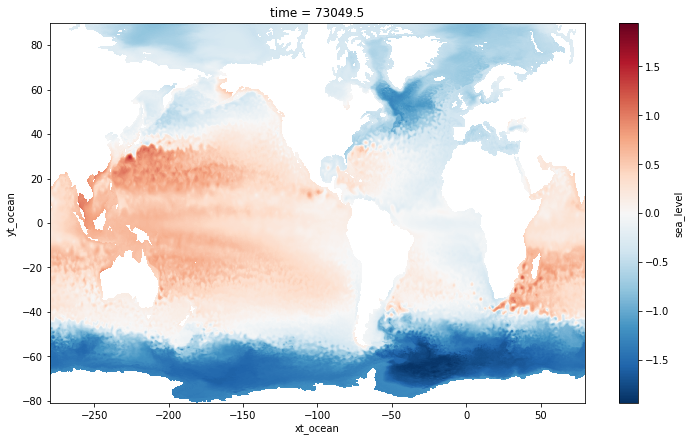

In [43]:
fig, ax = plt.subplots(figsize=(12,7))
ds.sea_level[-1].plot()

In [46]:
import zarr
# clevel up to 9 took **way** longer but had almost no effect on compression
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
encoding = {vname: {'compressor': compressor} for vname in ds.variables}

In [48]:
# just dump to zarr file
outdir_base = '/swot/SUM03/tmp/CM2.6'
dsname = 'surface_daily_'
outdir = os.path.join(outdir_base, experiment, dsname)
print(outdir)
try:
    print('removing')
    shutil.rmtree(outdir)
except FileNotFoundError:
    print('not found')
    pass

/swot/SUM03/tmp/CM2.6/control/surface_daily_
removing
not found


In [ ]:
ds.to_zarr(outdir)

In [10]:
ds

<xarray.Dataset>
Dimensions:         (nv: 2, st_ocean_sub01: 1, time: 7305, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 ...
  * nv              (nv) float64 1.0 2.0
  * st_ocean_sub01  (st_ocean_sub01) float64 5.034
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * time            (time) float64 6.575e+04 6.575e+04 6.575e+04 6.575e+04 ...
Data variables:
    htotal          (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700, 3600)>
    kw              (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700, 3600)>
    irr_mix         (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 1, 2700, 3600), 

In [12]:
os.path.join(outdir, expt, 'surface_daily')

'/swot/SUM03/tmp/CM2.6/one_percent/surface_daily/control/surface_daily'

In [51]:
# verify
for expt in ['control', 'one_percent']:
    dirname = os.path.join(outdir_base, expt, 'surface_daily')
    print(dirname)
    with xr.open_zarr(dirname) as ds_test:
        print(ds_test)

/swot/SUM03/tmp/CM2.6/control/surface_daily


/home/rpa/xarray/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/rpa/xarray/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


<xarray.Dataset>
Dimensions:         (nv: 2, st_ocean_sub01: 1, time: 7305, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * nv              (nv) float64 1.0 2.0
  * st_ocean_sub01  (st_ocean_sub01) float64 5.034
  * time            (time) object  181-01-01 12:00:00  181-01-02 12:00:00 ...
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 ...
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
Data variables:
    biomass_p       (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700, 3600)>
    chl             (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700, 3600)>
    dic             (time, yt_ocean, xt_ocean) float32 dask.array<shape=(7305, 2700, 3600), chunksize=(1, 2700, 

In [9]:
varname = 'v'
zstore1 = ds[[varname]].isel(time=0).reset_coords(drop=True).to_zarr('zarr_compression_test_1', mode='w')
zstore1.ds[varname].info

KeyError: 'v'

In [49]:
zstore2 = ds[[varname]].isel(time=0).reset_coords(drop=True).to_zarr('zarr_compression_test_2', mode='w',
                                                                     encoding={varname: {'compressor': compressor}})
zstore2.ds[varname].info

Name,/v
Type,zarr.core.Array
Data type,float32
Shape,"(50, 2700, 3600)"
Chunk shape,"(1, 2700, 3600)"
Order,C
Read-only,False
Compressor,"Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1944000000 (1.8G)
No. bytes stored,821655975 (783.6M)


In [58]:
(ds.temp[0] > 0).sum().load()

<xarray.DataArray 'temp' ()>
array(194025727)
Coordinates:
    time     float64 6.575e+04

In [55]:
ds.temp[0].shape

(50, 2700, 3600)

In [59]:
50 * 2700 * 3600 / 194025727

2.504822466146461

In [19]:
ds.to_zarr(outdir, encoding=encoding)

distributed.utils - ERROR - store-54b6a835ebc2867d21c4be0ed9e843cd
Traceback (most recent call last):
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/distributed/client.py", line 1346, in _gather
    st = self.futures[key]
KeyError: 'store-54b6a835ebc2867d21c4be0ed9e843cd'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/distributed/utils.py", line 237, in f
    result[0] = yield make_coro()
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/gen.py", line 1063, in run


KeyboardInterrupt: 

In [8]:
# connect to gcs
#token = '/home/rpa/pangeo-bf62fe06ed97.json'
token = 'cache'
fs = gcsfs.GCSFileSystem(project='pangeo-181919', token=token)
fs.buckets

['pangeo',
 'pangeo-data',
 'pangeo-data-private',
 'storage-benchmarks',
 'zarr_store_test']

In [9]:
fs.project

'pangeo-181919'

In [10]:
dsname = 'temp_salt_u_v-5day_avg'
path = 'pangeo-data/cm2.6/' + experiment + '/' + dsname
print(path)

pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg


In [11]:
! gsutil du -hs gs://pangeo-data/cm2.6/one_percent
! gsutil du -hs gs://pangeo-data/cm2.6/control

3.59 TiB    gs://pangeo-data/cm2.6/one_percent
940.92 GiB  gs://pangeo-data/cm2.6/control


In [11]:
import subprocess
def manually_remove_gcs_path(path):
    subprocess.check_call(['gsutil', '-q', '-m', 'rm', '-rf', 'gs://' + path])

In [21]:
# ! gsutil -q -m rm -rf gs://pangeo-data/cm2.6/one_percent
manually_remove_gcs_path(path)

In [23]:
gcsmap = gcsfs.mapping.GCSMap(path, gcs=fs, check=True, create=False)
gcsmap

In [12]:
# sanity check: make sure we can actually load the whole dataset
%time ds_mean = ds.mean()
ds_mean

CPU times: user 6.46 s, sys: 220 ms, total: 6.68 s
Wall time: 6.68 s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    u        float32 dask.array<shape=(), chunksize=()>
    temp     float32 dask.array<shape=(), chunksize=()>
    salt     float32 dask.array<shape=(), chunksize=()>
    v        float32 dask.array<shape=(), chunksize=()>

In [13]:
%time ds_mean.persist(retries=100)

CPU times: user 1min 55s, sys: 6.21 s, total: 2min 1s
Wall time: 2min 1s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    u        float32 dask.array<shape=(), chunksize=()>
    temp     float32 dask.array<shape=(), chunksize=()>
    salt     float32 dask.array<shape=(), chunksize=()>
    v        float32 dask.array<shape=(), chunksize=()>

In [26]:
del delayed_store

In [16]:
# this lock doesn't work for zarr
from dask.utils import SerializableLock
lock = SerializableLock()

In [19]:
synchronizer = zarr.ThreadSynchronizer()

In [24]:
# the big kahuna
%time delayed_store = ds.to_zarr(store=gcsmap, encoding=encoding, compute=False, synchronizer=synchronizer)

CPU times: user 30.9 s, sys: 1.01 s, total: 31.9 s
Wall time: 44.8 s


In [25]:
ds.nbytes / 1e12

11.352960113304

In [26]:
ds.nbytes / 1e6 / (18 * 60*60)

175.20000174851853

In [27]:
len(delayed_store.dask)

876081

In [31]:
del persist_store

In [28]:
%%time
%%snakeviz
persist_store = delayed_store.persist(retries=100)

 
*** Profile stats marshalled to file '/tmp/tmpu5usutze'. 
CPU times: user 1min 43s, sys: 3.23 s, total: 1min 46s
Wall time: 1min 46s


In [34]:
from dask.distributed import progress
progress(persist_store)

The installed widget Javascript is the wrong version.


In [22]:
persist_store

Delayed('store-4aa0f545d5a09c2eb66aeea472a0d870')

In [ ]:
1

In [20]:
persist_store

Delayed('store-ad633f4f2685024978bb8be560bc43e4')

In [29]:
persist_store.compute()

distributed.utils - ERROR - None: Max retries exceeded with url: /o/oauth2/token (Caused by None)
Traceback (most recent call last):
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/distributed/utils.py", line 237, in f
    result[0] = yield make_coro()
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/distributed/client.py", line 1356, in _gather
    traceback)
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/six.py", line 692, in 

TransportError: None: Max retries exceeded with url: /o/oauth2/token (Caused by None)

distributed.client - WARNING - Client report stream closed to scheduler
tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7fb7d63c8488>, <tornado.concurrent.Future object at 0x7fb761f982e8>)
Traceback (most recent call last):
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/distributed/comm/tcp.py", line 174, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home/rpa/.conda/envs/dask_distributed/lib/python3.5/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rpa/.conda/envs/dask_distributed/lib/pytho

In [42]:
del persist_store

In [13]:
# without reset_coords, zarr gives an error
# need to file an issue about this
ds_subset = ds.isel(time=slice(0,50)).reset_coords(drop=True)
ds_subset

<xarray.Dataset>
Dimensions:         (nv: 2, st_edges_ocean: 51, st_ocean: 50, time: 50, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 ...
  * st_ocean        (st_ocean) float64 5.034 15.1 25.22 35.36 45.58 55.85 ...
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 20.16 30.29 40.47 ...
  * nv              (nv) float64 1.0 2.0
  * time            (time) float64 6.94e+04 6.94e+04 6.941e+04 6.941e+04 ...
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<shape=(50, 50, 2700, 3600), chunksize=(1, 1, 2700, 3600)>
    salt            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<shape=(50, 50, 2700, 360

In [27]:
len(delayed_store.dask)

438041

In [31]:
# try to add a new worker
cluster.start_worker(ncores=16)

KeyboardInterrupt: 

In [29]:
client

KeyboardInterrupt: 

In [29]:
for k, v in delayed_store.dask.items():
    print(k, v)
    break

('store-concatenate-dda7e2a9bdd00de38820d6a6afbb671a', 82, 33, 0, 0) (<function store_chunk at 0x7fd17c3b2510>, ('concatenate-dda7e2a9bdd00de38820d6a6afbb671a', 82, 33, 0, 0), <zarr.core.Array '/v' (730, 50, 2700, 3600) float32>, (slice(82, 83, None), slice(33, 34, None), slice(0, 2700, None), slice(0, 3600, None)), False, False)


In [21]:
%time delayed_obj = ds_subset.to_zarr(store=gcsmap, encoding=encoding, compute=False)

CPU times: user 3.65 s, sys: 891 ms, total: 4.54 s
Wall time: 15.6 s


In [22]:
%%snakeviz
ds_subset_store = delayed_obj.persist()

 
*** Profile stats marshalled to file '/tmp/tmp4du2dng9'. 


In [23]:
del ds_subset_store

In [ ]:
# 51 min for 155 GB

In [25]:
ds_subset.nbytes / 1e9

388.800102024

In [ ]:
%time ds_subset.to_zarr(store=gcsmap, encoding=encoding)

In [17]:
client.run(lambda : fs.buckets)

{'tcp://129.236.21.48:34885': ['pangeo',
  'pangeo-data',
  'pangeo-data-private',
  'zarr_store_test']}

Nothing went in:

    $ gsutil du -h gs://pangeo-data/cm2.6
    2 B         gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/.zattrs
    24 B        gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/.zgroup
    314 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/nv/.zarray
    131 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/nv/.zattrs
    32 B        gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/nv/0
    477 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/nv/
    395 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/salt/.zarray
    401 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/salt/.zattrs
    796 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/salt/
    316 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_edges_ocean/.zarray
    179 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_edges_ocean/.zattrs
    325 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_edges_ocean/0
    820 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_edges_ocean/
    316 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_ocean/.zarray
    198 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_ocean/.zattrs
    324 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_ocean/0
    838 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/st_ocean/
    395 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/temp/.zarray
    423 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/temp/.zattrs
    818 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/temp/
    318 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/time/.zarray
    236 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/time/.zattrs
    976 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/time/0
    1.49 KiB    gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/time/
    395 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/u/.zarray
    395 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/u/.zattrs
    790 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/u/
    395 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/v/.zarray
    395 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/v/.zattrs
    790 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/v/
    320 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xt_ocean/.zarray
    144 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xt_ocean/.zattrs
    1.58 KiB    gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xt_ocean/0
    2.03 KiB    gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xt_ocean/
    320 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xu_ocean/.zarray
    144 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xu_ocean/.zattrs
    1.38 KiB    gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xu_ocean/0
    1.84 KiB    gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/xu_ocean/
    320 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yt_ocean/.zarray
    143 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yt_ocean/.zattrs
    13.81 KiB   gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yt_ocean/0
    14.27 KiB   gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yt_ocean/
    320 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yu_ocean/.zarray
    143 B       gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yu_ocean/.zattrs
    13.79 KiB   gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yu_ocean/0
    14.24 KiB   gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/yu_ocean/
    39.1 KiB    gs://pangeo-data/cm2.6/control/temp_salt_u_v-5day_avg/
    39.1 KiB    gs://pangeo-data/cm2.6/control/
    39.1 KiB    gs://pangeo-data/cm2.6/